In [1]:
import numpy as np
from matplotlib import pyplot as plt
import copy
from IPython.display import clear_output

np.random.seed(99)

In [2]:
def lin2db(x):
    return 10.0*np.log10(x)

def db2lin(x):
    return 10.0**(x/10.0)

def lin2dbm(x):
    return 10.0*np.log10(x)+30.0

def dbm2lin(x):
    return 10.0**(x/10.0 - 3.0)

In [3]:
def eCDF(data):
    x = np.sort(data)
    y = np.arange(0, len(data)) / len(data)

    return x, y  

In [4]:
# Functions related to positioning and distances

def random_ue_positions(num_ue, cov_side):
    ''' 
    Returns a random position vector within the coverage area.
    
    Parameters
    ----------
    cov_side : int, float
        The side [in m] of the coverage area.
    num_ue : int
        The number of UEs.
    '''
    
    ue_positions = np.zeros((num_ue, 2))
    
    for ue in range(num_ue):
        ue_positions[ue] = [np.random.rand() * cov_side, np.random.rand() * cov_side]
        
    return ue_positions


def ap_positions(num_ap, cov_side):
    ''' 
    Returns the APs positions based on the number of APs.
    
    Parameters
    ----------
    num_ap : int
        The number of APs.
    cov_side : int, float
        The side [in m] of coverage area.
    '''
    
    if np.sqrt(num_ap).is_integer():
        
        side_ap_quantity = int(np.sqrt(num_ap))
        
        ap_area_side = cov_side // side_ap_quantity
        
        x_pos, y_pos = np.meshgrid(np.arange(0.5 * ap_area_side,
                                             cov_side,
                                             ap_area_side),
                                   np.arange(0.5 * ap_area_side,
                                             cov_side,
                                             ap_area_side))
 
        aps_pos = np.column_stack((x_pos.ravel(), y_pos.ravel()))
    
        return aps_pos
    
    else:
        
        print('Number of APs must be a perfect square')


def distance(ue_pos, ap_pos, ref_distance=1):
    ''' 
    Returns the distance [in m] between an UE and an AP. If distance is lower than reference distance, it returns the reference distance.
    
    Parameters
    ----------
    ue_pos : int, float
        The UE position.
    ap_pos : int, float
        The AP position.
    ref_distance : int, float
        The reference distance [in m] from which the gain is calculated.
    '''

    dis_matrix = np.zeros((ue_pos.shape[0], ap_pos.shape[0]))
    
    for ue in range(ue_pos.shape[0]):
        for ap in range(ap_pos.shape[0]):
            dis = np.sqrt(((ue_pos[ue])[0] - (ap_pos[ap])[0])**2
                          + ((ue_pos[ue])[1] - (ap_pos[ap])[1])**2)

            if dis >= ref_distance:
                dis_matrix[ue, ap] = dis
            else:
                dis_matrix[ue, ap] = ref_distance

    return dis_matrix

In [5]:
def fpc_algorithm(path_loss, max_power, noise_power, compesation_factor, SNR):
    target_power  = SNR + noise_power + 30
    optimal_power = np.zeros((path_loss.shape[0]))

    for i in range(path_loss.shape[0]):
        beta = np.outer(path_loss[i:], path_loss[i,:].T)
        optimal_power[i] = np.min([max_power, db2lin(target_power) * (np.sqrt(np.trace(beta))) ** (-compesation_factor)])

    return optimal_power

In [217]:
def stepwise_removal(gain_matrix, distance_mat, SINR=0):

    power_vector = np.zeros(gain_matrix.shape[0])

    
    matrix_Z = np.zeros((gain_matrix.shape[0], gain_matrix.shape[0]))
    gain_array = np.zeros(gain_matrix.shape[0])
    
    aux_gain_matrix = copy.deepcopy(gain_matrix)
    new_matrix_Z = np.zeros((gain_matrix.shape[0], gain_matrix.shape[0]))
    
    for i in range(gain_matrix.shape[0]):
        gain_array[i] = sum(gain_matrix[i])

    for i in range(gain_matrix.shape[0]):
        matrix_Z[i] = gain_array / gain_array[i]
    
    target_SINR = db2lin(SINR) 
    aux_matrix_Z = copy.deepcopy(matrix_Z)
    
    while True:

        eigenvalues_matrix = np.linalg.eig(matrix_Z)[0]
        eigenvector_matrix = np.linalg.eig(matrix_Z)[1]
        
        max_eigenvalue = eigenvalues_matrix.max()
        index = np.where(eigenvalues_matrix == max_eigenvalue)
        
        max_eigenvector = eigenvector_matrix[index] 
        
        max_achievable_SINR = 1 / (max_eigenvalue - 1)
        
        if max_achievable_SINR >= target_SINR:

            for p in range(max_eigenvector[0].shape[0]):
                power_vector[p] = max_eigenvector[0][p]

            power_vector = np.where(power_vector==0, max_eigenvector[0][0], power_vector)
            break
            
        else:

            # Remove the better link 
            max_value = float('-inf')
            max_j = 0

            for j in range(matrix_Z.shape[0]):
             
                soma = sum(matrix_Z[j]) + sum(np.transpose(matrix_Z)[j])

                if soma > max_value:
                    max_value = soma
                    max_j = j

            new_matrix_Z[max_j] = aux_matrix_Z[max_j]
            
            matrix_Z = np.delete(matrix_Z, max_j, 0)
            matrix_Z = np.delete(matrix_Z, max_j, 1) 
            
            #aux_gain_matrix = np.delete(aux_gain_matrix, max_j, 0)
            
            distance_mat = np.delete(distance_mat, max_j, 0)

    
    return power_vector, distance_mat

In [143]:
def sra_algorithm(gain_matrix, SINR=0):

    power_vector = np.zeros(gain_matrix.shape[0])
    gains = copy.deepcopy(gain_matrix)

    while np.isin(0, power_vector):

        matrix_Z = np.zeros((gains.shape[0], gains.shape[0]))
        gain_array = np.zeros(gains.shape[0])
        
        for i in range(gains.shape[0]):
            gains[i] = sum(gains[i])
    
        for i in range(gains.shape[0]):
            matrix_Z[i] = gain_array / gain_array[i]
        
        target_SINR = db2lin(SINR) 

        while True:
    
            eigenvalues_matrix = np.linalg.eig(matrix_Z)[0]
            eigenvector_matrix = np.linalg.eig(matrix_Z)[1]
            
            max_eigenvalue = eigenvalues_matrix.max()
            index = np.where(eigenvalues_matrix == max_eigenvalue)
            
            max_eigenvector = eigenvector_matrix[index] 
            
            max_achievable_SINR = 1 / (max_eigenvalue - 1)

            
            
            
            if max_achievable_SINR >= target_SINR:

                power_vector = max_eigenvector
                    
                break
                
            else:
    
                # Remove the better link 
                max_value = float('-inf')
                max_j = 0
    
                for j in range(matrix_Z.shape[0]):
                 
                    soma = sum(matrix_Z[j]) + sum(np.transpose(matrix_Z)[j])
    
                    if soma > max_value:
                        max_value = soma
                        max_j = j
    
                new_matrix_Z[max_j] = aux_matrix_Z[max_j]
                
                matrix_Z = np.delete(matrix_Z, max_j, 0)
                matrix_Z = np.delete(matrix_Z, max_j, 1) 
            
        
    

In [7]:
def gain(hor_distance, shadow):
    
    return db2lin(- shadow - 30.5 -36.7*np.log10(np.sqrt(hor_distance**2 + 10**2)))

In [8]:
# Functions related to channel modeling

def snr_cellfree(hor_distance, power):

    return db2lin(- 2*np.random.randn() + power + 96 - 30.5 -36.7*np.log10(np.sqrt(hor_distance**2 + 10**2)))

def channel_gain(snr):

    channel_matrix = np.zeros(snr.shape)
    for ue in range(snr.shape[0]):
        channel_matrix[ue,:] = np.sqrt(snr[ue, :])
        
    return channel_matrix

In [9]:
def mmse_sinr(channel_m):

    M = channel_m.shape[1]
    sinr = np.zeros(channel_m.shape[0])
    sum = 0
    
    for ue in range(channel_m.shape[0]):
        
        sum += channel_m[ue] @ channel_m[ue].T
        
    for ue in range(channel_m.shape[0]):
         
        sinr[ue] = channel_m[ue].T @ np.linalg.inv(sum - channel_m[ue] @ channel_m[ue].T + np.eye(M)) @ channel_m[ue]
        
    return sinr

In [218]:
def simulation(ue_quantity):

    num_ue = ue_quantity
    num_ap = 64
    cov_side = 400 # [m]
    seeds = 1000
    noise_gain = 1e-20 * 100e6 * db2lin(6)
    noise_p = -96 # [dBm]
    max_power = dbm2lin(30)
    
    total_sinr_mp = np.zeros((num_ue, seeds))
    total_sinr_fpc = np.zeros((num_ue, seeds))
    total_sinr_sra = []
    
    total_power_mp = np.zeros(seeds)
    total_power_fpc = np.zeros(seeds)
    total_power_sra = np.zeros(seeds)
    
    for seed in range(seeds):
    
        ue_pos = random_ue_positions(num_ue, cov_side)
        ap_pos = ap_positions(num_ap, cov_side)
        distances = distance(ue_pos, ap_pos)
        
        
        shadowing = 2*np.random.randn(num_ue, num_ap)
        gains = gain(distances, shadowing)
        
        
        # Max Power
        power_mp = np.ones((num_ue, num_ap)) * max_power
        
        
        # Fractional Power Control
        power_fpc = fpc_algorithm(gains, max_power, noise_p, 0.8, 0)
        fpc_matrix = np.ones((num_ue, num_ap))
    
        for row in range(num_ue):
            
            fpc_matrix[row] = fpc_matrix[row] * power_fpc[row]  
    
    
        # Stepwise Removal Algorithm
        sra = stepwise_removal(gains, distances, 0)
        power_sra = np.abs(sra[0])
        distances_sra = sra[1]
        
        sra_matrix = np.ones((num_ue, num_ap))
        
        for row in range(power_sra.shape[0]):
            sra_matrix[row] = sra_matrix[row] * power_sra[row]
            
            
        snr_mp = snr_cellfree(distances, lin2db(power_mp)) 
        snr_fpc = snr_cellfree(distances, lin2db(fpc_matrix))
        snr_sra = snr_cellfree(distances, lin2db(sra_matrix))
        
        channels_mp = channel_gain(snr_mp)
        channels_fpc = channel_gain(snr_fpc)
        channels_sra = channel_gain(snr_sra)
        
        total_power_mp[seed] = num_ue
        total_power_fpc[seed] = sum(power_fpc)
        total_power_sra[seed] = sum(power_sra)
        
        # print(power_sra.shape)
        # print('seed: ', seed)
        clear_output(wait=True)
        
        for ue in range(num_ue):
            total_sinr_mp[:, seed] = lin2db(mmse_sinr(channels_mp))
            total_sinr_fpc[:, seed] = lin2db(mmse_sinr(channels_fpc))
        
        for ch in range(power_sra.shape[0]):
            total_sinr_sra = np.concatenate((total_sinr_sra, lin2db(mmse_sinr(channels_sra))))

    return total_sinr_mp, total_sinr_fpc, total_sinr_sra, total_power_mp, total_power_fpc, total_power_sra

In [219]:
# Simulations for different number of UEs

simulation_2 = simulation(2)
simulation_4 = simulation(4)
simulation_8 = simulation(8)
simulation_16 = simulation(16)

In [220]:
np.median(simulation_8[2])

15.591609852162975

[ 1  5  9 13]


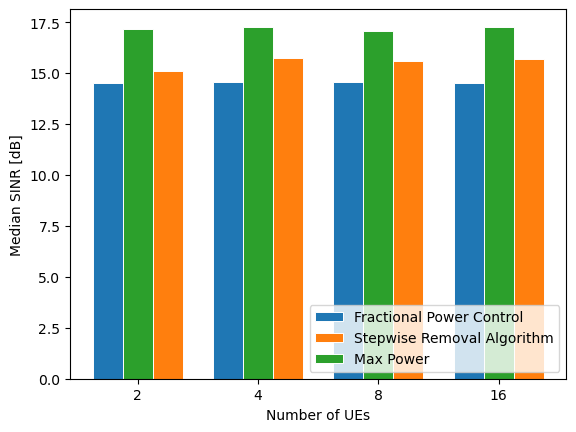

In [231]:
# make data:
x = 0.5 + np.arange(8)
y = [4.8, 5.5, 3.5, 4.6, 6.5, 6.6, 2.6, 3.0]

# plot
fig, ax = plt.subplots()

mp_sinr_medians = np.array([
    np.median(simulation_2[0]),
    np.median(simulation_4[0]),
    np.median(simulation_8[0]),
    np.median(simulation_16[0]),
])

fpc_sinr_medians = np.array([
    np.median(simulation_2[1]),
    np.median(simulation_4[1]),
    np.median(simulation_8[1]),
    np.median(simulation_16[1]),
])

sra_sinr_medians = np.array([
    np.median(simulation_2[2]),
    np.median(simulation_4[2]),
    np.median(simulation_8[2]),
    np.median(simulation_16[2]),
])

xs = np.array([
    np.arange(15, step=4),
    np.arange(1, 15, step=4),
    np.arange(2, 15, step=4),
])

ax.bar(xs[0], fpc_sinr_medians, width=1, edgecolor="white", linewidth=0.7, label='Fractional Power Control')
ax.bar(xs[2], sra_sinr_medians, width=1, edgecolor="white", linewidth=0.7, label='Stepwise Removal Algorithm')
ax.bar(xs[1], mp_sinr_medians, width=1, edgecolor="white", linewidth=0.7, label='Max Power')

x_labels = ['2', '4', '8', '16']
ax.set_ylabel('Median SINR [dB]')
ax.set_xlabel('Number of UEs')
print(xs[1])
ax.set_xticks(xs[1], x_labels)
ax.legend(loc='lower right')

plt.savefig('SINR_graphbar_SBrT2024.pdf')

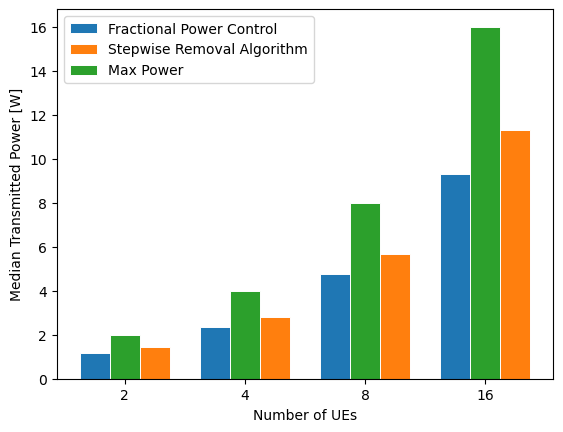

In [232]:
# make data:
x = 0.5 + np.arange(8)
y = [4.8, 5.5, 3.5, 4.6, 6.5, 6.6, 2.6, 3.0]

# plot
fig, ax = plt.subplots()

mp_pow_medians = np.array([
    np.median(simulation_2[3]),
    np.median(simulation_4[3]),
    np.median(simulation_8[3]),
    np.median(simulation_16[3]),
])

fpc_pow_medians = np.array([
    np.median(simulation_2[4]),
    np.median(simulation_4[4]),
    np.median(simulation_8[4]),
    np.median(simulation_16[4]),
])

sra_pow_medians = np.array([
    np.median(simulation_2[5]),
    np.median(simulation_4[5]),
    np.median(simulation_8[5]),
    np.median(simulation_16[5]),
])

xs = np.array([
    np.arange(15, step=4),
    np.arange(1, 15, step=4),
    np.arange(2, 15, step=4),
])

ax.bar(xs[0], fpc_pow_medians, width=1, edgecolor="white", linewidth=0.7, label='Fractional Power Control')
ax.bar(xs[2], sra_pow_medians, width=1, edgecolor="white", linewidth=0.7, label='Stepwise Removal Algorithm')
ax.bar(xs[1], mp_pow_medians, width=1, edgecolor="white", linewidth=0.7, label='Max Power')

x_labels = ['2', '4', '8', '16']
ax.set_ylabel('Median Transmitted Power [W]')
ax.set_xlabel('Number of UEs')
ax.set_xticks(xs[1], x_labels)
ax.legend(loc='upper left')

plt.savefig('Capacity_graphbar_SBrT2024.pdf')

In [226]:
 np.median(simulation_4[5]) / np.median(simulation_4[3])

0.7062235558009906

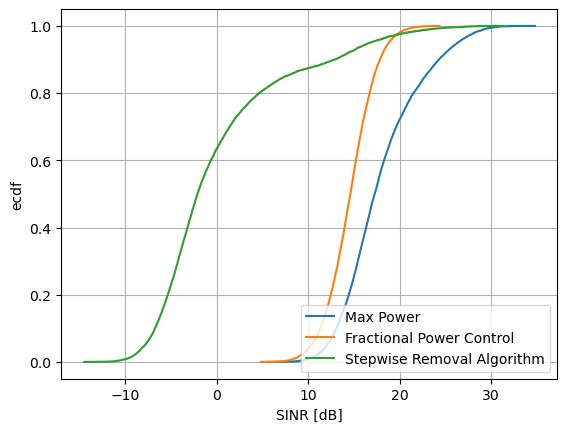

In [204]:
sinr_cdf_mp = eCDF(simulation_16[0].flatten())
plt.plot(sinr_cdf_mp[0], sinr_cdf_mp[1], label='Max Power')

sinr_cdf_fpc = eCDF(simulation_16[1].flatten())
plt.plot(sinr_cdf_fpc[0], sinr_cdf_fpc[1], label='Fractional Power Control')

sinr_cdf_sra = eCDF(simulation_16[2].flatten())
plt.plot(sinr_cdf_sra[0], sinr_cdf_sra[1], label='Stepwise Removal Algorithm')

#plt.xlim([5,30])
plt.xlabel('SINR [dB]')
plt.ylabel('ecdf')
plt.legend(loc='lower right')
plt.grid()
plt.savefig('SINR_power_control_SBrT2024.pdf')

In [18]:
# capacity_mp_cdf = eCDF((20e6 * np.log2(1 + db2lin(total_sinr_mp))).flatten())
# plt.plot(capacity_mp_cdf[0] / 1e6, capacity_mp_cdf[1], label='Max Power')

# capacity_fpc_cdf = eCDF((20e6 * np.log2(1 + db2lin(total_sinr_fpc))).flatten())
# plt.plot(capacity_fpc_cdf[0] / 1e6, capacity_fpc_cdf[1], label='Fractional Power Control')

# capacity_sra_cdf = eCDF((20e6 * np.log2(1 + db2lin(total_sinr_sra))).flatten())
# plt.plot(capacity_sra_cdf[0] / 1e6, capacity_sra_cdf[1], label='Stepwise Removal Algorithm')


# plt.xlabel('Capacity [Mbps]')
# plt.ylabel('ecdf')

# plt.xlim([35,220])

# plt.legend(loc='lower right')
# plt.grid()
# plt.savefig('Capacity_power_control_SBrT2024.pdf')